#### Задание 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_regression
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import random

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

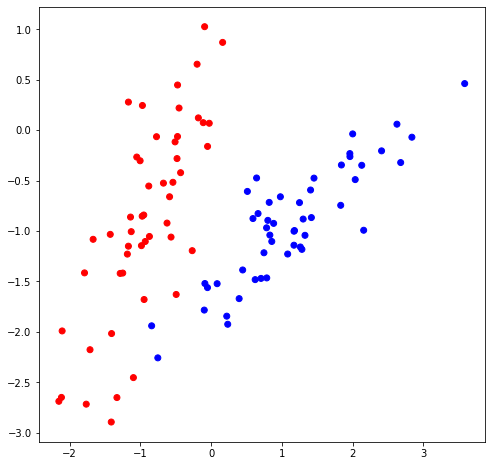

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла (вершины)

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

**Возьмем в качестве критерия останова:**   

 - количество используемых признаков  - ограничим в функции find_best_split
 - глубина дерева  - ограничим в функции build_tree


In [9]:
# Нахождение наилучшего разбиения с ограничением количества используемых признаков

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле

    min_samples_leaf = 5
    
    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    i = 0
    
    #Ограничим количество признаков, чтобы при каждом запуске функции выбирались разные случайные группы признаков
    n_features = np.random.randint(data.shape[1], size = 3)
    
    for index in n_features:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
        
    return best_gain, best_t, best_index

**Попробуем ограничить глубину дерева**

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth, max_depth):
    
    gain, t, index = find_best_split(data, labels)

    #  Прекращаем рекурсию, когда нет прироста в качества или когда достигли максимальной глубины дерева
    
    if gain == 0 or depth == max_depth:
        return Leaf(data, labels)


    # Находим лучшее разбиение
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth+1, max_depth)
    import time
    print(time.time(), true_branch)

    false_branch = build_tree(false_data, false_labels, depth+1, max_depth)
    print(time.time(), false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
    return Node(index, t, true_branch, false_branch)
    
    

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 0, 5)

1629539621.593941 <__main__.Leaf object at 0x7fb12a7fea60>
1629539621.594829 <__main__.Leaf object at 0x7fb12a812d90>
1629539621.5950809 <__main__.Leaf object at 0x7fb12a6e8190>
1629539621.595115 <__main__.Node object at 0x7fb12a6fe070>
1629539621.5951412 <__main__.Node object at 0x7fb12a6fe250>
1629539621.597572 <__main__.Leaf object at 0x7fb12a6e8f70>
1629539621.599545 <__main__.Leaf object at 0x7fb12a6e8ee0>
1629539621.599584 <__main__.Node object at 0x7fb12a812850>
1629539621.599612 <__main__.Node object at 0x7fb12a6fe310>
1629539621.600207 <__main__.Leaf object at 0x7fb12a6e8eb0>


In [15]:
my_tree.true_branch

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.05877427080072417
--> True:
  Индекс 0 <= -0.26751423090801474
  --> True:
    Индекс 0 <= -0.8725985883473684
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.5403007857080191
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс 0 <= 0.08490007282712542
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
--> False:
  Прогноз: 0


In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
np.array(train_answers)

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1])

In [18]:
# И получим ответы для тестовой выборки
test_answers = predict(test_data, my_tree)
np.array(test_answers)

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0])

In [19]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 97.14285714285714
Test accuracy 93.33333333333333


#### Задание 2. *Реализуйте дерево для задачи регрессии.   
**Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [21]:
X, Y = make_regression(n_samples=1000, n_features=2, n_informative=4, n_targets=1, 
                                      noise=5, coef=False, random_state=2)

In [22]:
# Реализуем класс узла (вершины)

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [23]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()
        
    def predict(self):
        
        # предскажем значение как среднее по выборке    
        prediction = np.mean(self.values)
        return prediction        

In [24]:
# Расчет критерия Джини

#values - значения целевой переменной в выборке
def gini(values):
    values = list(values)
    mean_value = np.mean(values)
    
    deviation = 0
    for value in values:
        deviation += (value - mean_value)**2
    
    return deviation/len(values)

In [25]:
# Расчет прироста

def gain(left_values, right_values, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])
    
    return root_gini - p * gini(left_values) - (1 - p) * gini(right_values)

In [26]:
# Разбиение датасета в узле

def split(data, values, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_values = values[left]
    false_values = values[right]
        
    return true_data, false_data, true_values, false_values

In [27]:
# Нахождение наилучшего разбиения

def find_best_split(data, values):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(values)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_values, false_values = split(data, values, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_values, false_values, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [28]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, values):

    gain, t, index = find_best_split(data, values)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, values)

    true_data, false_data, true_values, false_values = split(data, values, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_values)
    import time
    print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_values)
    
    print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [29]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [30]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [31]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_values, test_values = train_test_split(X, 
                                                                    Y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [32]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_values)

1629539622.375067 <__main__.Leaf object at 0x7fb12a70a400>
1629539622.38038 <__main__.Leaf object at 0x7fb12a70a4f0>
1629539622.380718 <__main__.Leaf object at 0x7fb12a70a670>
1629539622.380747 <__main__.Node object at 0x7fb12a726760>
1629539622.380896 <__main__.Leaf object at 0x7fb12a7261c0>
1629539622.3809159 <__main__.Node object at 0x7fb12a726700>
1629539622.383738 <__main__.Leaf object at 0x7fb12a70a340>
1629539622.384346 <__main__.Leaf object at 0x7fb12a70a730>
1629539622.3845088 <__main__.Leaf object at 0x7fb12a7260a0>
1629539622.384528 <__main__.Node object at 0x7fb12a7266a0>
1629539622.3845508 <__main__.Node object at 0x7fb12a726af0>
1629539622.385191 <__main__.Leaf object at 0x7fb12a726b20>
1629539622.385387 <__main__.Leaf object at 0x7fb12a726910>
1629539622.385406 <__main__.Node object at 0x7fb12a726f70>
1629539622.385422 <__main__.Node object at 0x7fb12a726250>
1629539622.3854358 <__main__.Node object at 0x7fb12a8129d0>
1629539622.385449 <__main__.Node object at 0x7fb12a81

1629539622.800413 <__main__.Leaf object at 0x7fb108fecdc0>
1629539622.8006349 <__main__.Leaf object at 0x7fb108ff08b0>
1629539622.800659 <__main__.Node object at 0x7fb108ff00a0>
1629539622.8013399 <__main__.Leaf object at 0x7fb108fecca0>
1629539622.801491 <__main__.Leaf object at 0x7fb108ff0220>
1629539622.8015099 <__main__.Node object at 0x7fb108ff06d0>
1629539622.801631 <__main__.Node object at 0x7fb108feca60>
1629539622.812125 <__main__.Leaf object at 0x7fb108fecc10>
1629539622.812427 <__main__.Leaf object at 0x7fb108ff0340>
1629539622.8125591 <__main__.Node object at 0x7fb108ff0910>
1629539622.812756 <__main__.Leaf object at 0x7fb108ff0460>
1629539622.812885 <__main__.Node object at 0x7fb108ff03a0>
1629539622.814394 <__main__.Leaf object at 0x7fb108fece50>
1629539622.8147452 <__main__.Leaf object at 0x7fb108ff0430>
1629539622.81477 <__main__.Node object at 0x7fb108ff0250>
1629539622.814786 <__main__.Node object at 0x7fb108ff0a90>
1629539622.816679 <__main__.Leaf object at 0x7fb108f

In [33]:
my_tree

In [34]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.26448360406258725
--> True:
  Индекс 0 <= 0.132924055186507
  --> True:
    Индекс 1 <= -1.1648113258867563
    --> True:
      Индекс 0 <= -1.8532888650882562
      --> True:
        Прогноз: -258.9711616411409
      --> False:
        Индекс 1 <= -1.7934355851948631
        --> True:
          Индекс 0 <= -0.4151419697731788
          --> True:
            Индекс 1 <= -2.1686184989032724
            --> True:
              Прогноз: -211.06917829285103
            --> False:
              Прогноз: -184.4308979575206
          --> False:
            Прогноз: -161.57506783287204
        --> False:
          Индекс 0 <= -0.5007914895154542
          --> True:
            Индекс 0 <= -0.9276791698587648
            --> True:
              Прогноз: -183.03582723854944
            --> False:
              Индекс 1 <= -1.6354064332773162
              --> True:
                Прогноз: -153.91593251975786
              --> False:
                Прогноз: -140.46146717216192
   

In [37]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [38]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)